In [1]:
import extFunc as ext
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np
from importlib import import_module
import pandas as pd 
import cobra
import optlang
import copy 
import random

In [2]:
#Load Models if not already in RAM

#nameList = ['iJN1462_GLC_UR10_9.xml' , 'iJN1462_GLC_UR6_3.xml', 'iJN1462_GLN_UR5_1.xml', 'iJN1462_GLC_UR7_3.xml' , 'iJN1462_OCT_UR3_4.xml']
#nameList = ['iJN1462_GLC_UR6_3.xml' , 'iJN1462_OCT_UR3_4.xml']
nameList = ['iJN1462_OCT_UR3_4.xml']

if 'modelDict' not in locals():
    modelDict = ext.ImportFunction(nameList)



if 'glc_oct_comp'  not in locals():
    glc_oct_comp = ext.ModelComparison(modelDict=modelDict)


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
#Base case as in Nogales Paper
model           = modelDict['iJN1462_OCT_UR3_4']
model_bounded   = copy.deepcopy(model)

fv                  = cobra.flux_analysis.flux_variability_analysis(model)
fv["cumulative"]    = abs(fv.maximum) + abs(fv.minimum)


<AxesSubplot:>

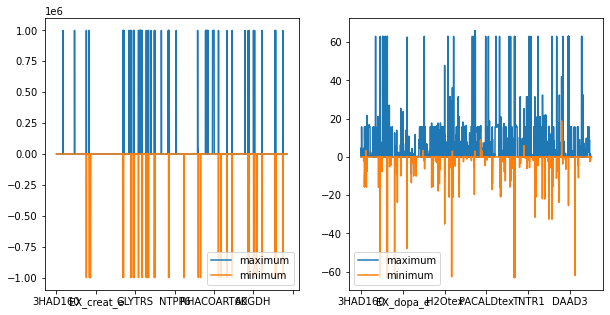

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fv.plot( y=["maximum", "minimum"],ax=axes[0])
fv[(abs(fv.maximum)<200)&(abs(fv.minimum)<200)].plot( y=["maximum", "minimum"],ax=axes[1])



In [ ]:
list_of_filtered = fv[(abs(fv.maximum)<200)&(abs(fv.minimum)<200)]


In [14]:

bounded_model = copy.deepcopy(model)
fv          = cobra.flux_analysis.flux_variability_analysis(model)

for reaction in model.reactions:
    if abs(reaction.lower_bound)>50:
        reaction.lower_bound= -50
    if abs(reaction.upper_bound)>50:
        reaction.upper_bound=50
        
fv_new_model  = cobra.flux_analysis.flux_variability_analysis(bounded_model)


<AxesSubplot:>

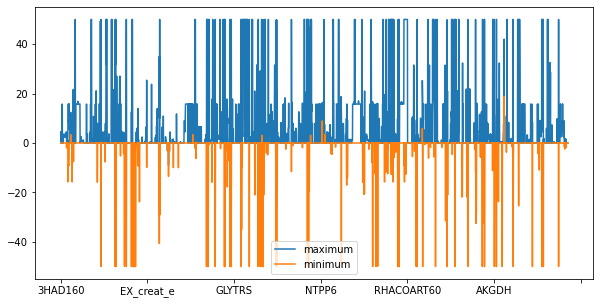

In [16]:
fv_new_model.plot( y=["maximum", "minimum"] )
